<a href="https://colab.research.google.com/github/chinaza2002/crisismanagerApp/blob/main/sentimentAnalyzer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Add your login details

1. Click on the 🔑 Secrets tab in the left panel.
   
   <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
  
1. Create a new secret with the name username.

2. Copy/paste your username into the Value input box of username.

3. Toggle the button on the left to allow notebook access to the secret.

4. Repeat the process two more times and name the secrets email and twitterPassword respectively.

# Data Collection from X formely Twitter.

In [ ]:
!pip install twikit

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 17.8 MB/s eta 0:00:00
  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25982 sha256=913a03c8ae1fb565dbd6ba1b82f3cabc58c13f34a4f11e0e7b9297b81f57dbc9
  Stored in directory: /root/.cache/pip/wheels/a5/9a/30/1003e89ab4555b81840ca46d361bf184f1e6ad880cae3b62a9
Successfully built pyjsparser


In [ ]:
import asyncio
import csv
from twikit import Client
from google.colab import userdata, files
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

USERNAME = userdata.get('username')
EMAIL = userdata.get('email')
PASSWORD = userdata.get('twitterPassword')

client = Client('en-US')

async def main():
    await client.login(
        auth_info_1=USERNAME ,
        auth_info_2=EMAIL,
        password=PASSWORD
    )

await main()

In [ ]:
container = []
tweets = await client.search_tweet(input('Enter your query here: '), 'Latest', count=20)

for _ in range(400):
    if not tweets:
        break
    container.extend(tweets)
    try:
        tweets = await tweets.next()
        await asyncio.sleep(20)
    except Exception as e:
        print(f"An error occurred: {e}")
        break

container2 = [[tweet.user.name, tweet.text, tweet.created_at] for tweet in container]
filename = "query_tweets.csv"
with open(filename, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["username", "tweet", "createdAt"])
    writer.writerows(container2)
    files.download(filename)

Enter your query here: air india crash


AccountSuspended: status: 429, message: "{"errors":[{"code":88,"message":"Rate limit exceeded."}]}"

# Installation of Dependecies for Sentiment Analysis

In [ ]:
!pip install tensorflow

In [ ]:
!pip install pandas
!pip install numpy
!pip install pandas
!pip install numpy
!pip install nltk
!pip install scikit-learn
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import pickle

# Reading of Labeled Dataset

In [ ]:
max_words = 10000
max_length = 100
embedding_dim = 100
lstm_units = 128

df = pd.read_csv('Tweets_for_training.csv')
texts = df['text'].values
labels = df['sentiment'].values

# Pre-processing Function

In [ ]:
import re
def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

texts = [preprocess_text(t) for t in texts]



# Tokenization, Embedding, Model Building and Training.

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Load GloVe embeddings
embeddings_index = {}
with open('a2_glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build model
model = Sequential()
model.add(Embedding(max_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))
model.add(LSTM(lstm_units))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Define your label mapping
labels = df['sentiment'].map(label_mapping).values  # Apply mapping to labels column


# Train model
model.fit(padded_sequences, labels, epochs=25, batch_size=64, validation_split=0.2)

# Save model and tokenizer
model.save('model.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 112s 317ms/step - accuracy: 0.5197 - loss: 0.9740 - val_accuracy: 0.6476 - val_loss: 0.8048
Epoch 2/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 112s 325ms/step - accuracy: 0.6628 - loss: 0.7868 - val_accuracy: 0.6918 - val_loss: 0.7315
Epoch 3/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 139s 317ms/step - accuracy: 0.6837 - loss: 0.7307 - val_accuracy: 0.7006 - val_loss: 0.7202
Epoch 4/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 108s 315ms/step - accuracy: 0.7049 - loss: 0.6999 - val_accuracy: 0.7077 - val_loss: 0.6984
Epoch 5/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 110s 321ms/step - accuracy: 0.7216 - loss: 0.6739 - val_accuracy: 0.7137 - val_loss: 0.6926
Epoch 6/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 139s 312ms/step - accuracy: 0.7201 - loss: 0.6597 - val_accuracy: 0.7148 - val_loss: 0.6813
Epoch 7/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 109s 317ms/step - accuracy: 0.7395 - loss: 0.6257 - val_accuracy: 0.7202 - val_loss: 0.6815
Epoch 8/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 143s 322ms/step - accuracy: 0.7488 -

# Model Evaluation and Testing

In [ ]:
score = model.evaluate(padded_sequences, labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3481573760509491
Test accuracy: 0.9014955759048462


In [ ]:
pred = model.predict(padded_sequences)
pred_labels = np.argmax(pred, axis=1)
print(classification_report(labels, pred_labels))

859/859 ━━━━━━━━━━━━━━━━━━━━ 57s 66ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      7781
           1       0.87      0.92      0.89     11118
           2       0.93      0.90      0.92      8582

    accuracy                           0.90     27481
   macro avg       0.91      0.90      0.90     27481
weighted avg       0.90      0.90      0.90     27481



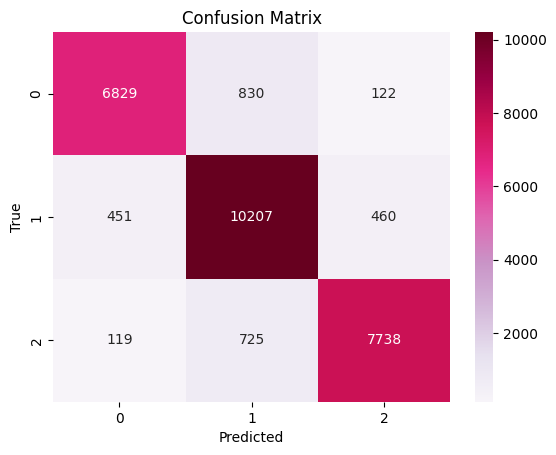

In [ ]:
conf_mat = confusion_matrix(labels, pred_labels)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='PuRd')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Sentiment Analysis for sample Dataset

In [ ]:
model = tf.keras.models.load_model('model.h5')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
max_length = 100

sample_tweets = pd.read_csv('query_tweets.csv')
tweets = sample_tweets['tweet'].apply(preprocess_text).values

In [ ]:
sequences = tokenizer.texts_to_sequences(tweets)
padded = pad_sequences(sequences, maxlen=max_length)

predictions = model.predict(padded)
sentiments = [['Negative', 'Neutral', 'Positive'][np.argmax(p)] for p in predictions]

sample_tweets['Sentiment'] = sentiments
print(sample_tweets)
sample_tweets.to_csv('querytweetswith_sentiment.csv', index=False)

negative_tweets_count = sample_tweets[sample_tweets['Sentiment'] == 'Negative'].shape[0]
print(f"Number of negative tweets: {negative_tweets_count}")

positive_tweets_count = sample_tweets[sample_tweets['Sentiment'] == 'Positive'].shape[0]
print(f"Number of positive tweets: {positive_tweets_count}")

neutral_tweets_count = sample_tweets[sample_tweets['Sentiment'] == 'Neutral'].shape[0]
print(f"Number of neutral tweets: {neutral_tweets_count}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
                               username  \
0                             Just Ozed   
1                            ARISE NEWS   
2                             Just Ozed   
3                      Ayowole Adewola™   
4                           Omoniyi Dan   
..                                  ...   
72                       Newtelegraphng   
73                                 Grok   
74  Al-hamdaany Al-Adaby Abdullah Arije   
75                                 Grok   
76                     Murtala RAJI,cln   

                                                tweet  \
0   Please Join us on YouTube (Just Ozed) at 5pm N...   
1   Tinubu Hails Umahi Over Coastal Highway\n\nThe...   
2   Hello everyone! Please Join us LIVE at 5pm Nig...   
3   @rwg6cdcpjx @objectvmedia ITB is not the contr...   
4   What has failed? The Lekki Free Zone? Dangote ...   
..                                                ...   
72  Tinubu Dismisses Criticisms, Says Only 47

In [ ]:
sample_tweets.head(60)
# files.download('querytweetswith_sentiment.csv')

,username,tweet,createdAt,Sentiment
0,Just Ozed,Please Join us on YouTube (Just Ozed) at 5pm N...,Fri Jun 06 13:56:44 +0000 2025,Positive
1,ARISE NEWS,Tinubu Hails Umahi Over Coastal Highway\n\nThe...,Fri Jun 06 13:45:14 +0000 2025,Neutral
2,Just Ozed,Hello everyone! Please Join us LIVE at 5pm Nig...,Fri Jun 06 13:44:21 +0000 2025,Positive
3,Ayowole Adewola™,@rwg6cdcpjx @objectvmedia ITB is not the contr...,Fri Jun 06 13:28:11 +0000 2025,Neutral
4,Omoniyi Dan,What has failed? The Lekki Free Zone? Dangote ...,Fri Jun 06 13:26:04 +0000 2025,Negative
5,REMEDY BLOG 👀,Nigerian man takes it upon himself to travel t...,Fri Jun 06 13:05:38 +0000 2025,Negative
6,Paabu Ishaya-Jibo Naneto,The brain behind the Lekki Free Zone is the sa...,Fri Jun 06 13:05:11 +0000 2025,Negative
7,kolaqhazim,A Nigerian man’s video claims the 30km Lagos-C...,Fri Jun 06 12:54:26 +0000 2025,Negative
8,SEA KING 🐬🌊🧜‍♂️,The Lagos calabar coastal road to:\nILLEGAL DE...,Fri Jun 06 12:51:02 +0000 2025,Negative
9,NigerianReports,Lagos-Calabar Coastal Road: FG to revoke appro...,Fri Jun 06 12:12:14 +0000 2025,Neutral


In [ ]:
negativeTweets_df = sample_tweets[sample_tweets['Sentiment'] == 'Negative']
negativeTweets = negativeTweets_df['tweet'].tolist()
# print(negativeTweets)

In [ ]:
# Calculate the total number of tweets
total_tweets = sample_tweets.shape[0]

# Calculate the percentage of negative tweets
percentage_negative_tweets = round(((negative_tweets_count / total_tweets) * 100), 2)
percentage_positive_tweets = round(((positive_tweets_count / total_tweets) * 100), 2)
percentage_neutral_tweets = round(((neutral_tweets_count / total_tweets) * 100), 2)

print(f"Total number of Tweets: {total_tweets}")
print(f"Positive Tweet Percentage: {percentage_positive_tweets}%")
print(f"Neutral Tweet Percentage: {percentage_neutral_tweets}%")
print(f"Negative Tweet Percentage: {percentage_negative_tweets}%")

Total number of Tweets: 77
Positive Tweet Percentage: 7.79%
Neutral Tweet Percentage: 55.84%
Negative Tweet Percentage: 36.36%


In [ ]:
!pip install openai

In [ ]:
from openai import OpenAI

In [ ]:
clientKey = OpenAI(api_key = userdata.get('client_key'))

In [ ]:
def get_crisis_management_strategy(negativeTweets, tone="pr"):
    """
    Generate crisis management strategies in the specified tone:
    - 'pr' for a formal public relations tone
    - 'internal' for internal crisis team action items
    """

    summary = "\n".join(negativeTweets[:10])  # Cap at 10 tweets to reduce tokens

    if tone == "pr":
        style_instructions = (
            "Provide a formal public relations response plan. "
            "Use polished, professional language suitable for public communication. "
            "Include recommended statements, apology language, and public-facing actions."
        )
    elif tone == "internal":
        style_instructions = (
            "Provide internal crisis response strategies for the company’s crisis team. "
            "List specific action steps, responsible teams (e.g., Engineering, Support, Comms), "
            "and escalation procedures. Avoid PR or customer language."
        )
    else:
        raise ValueError("Tone must be 'pr' or 'internal'")

    prompt = f"""
You are a crisis management expert. Based on these negative tweets about a product, provide 3–5 crisis management strategies. Don't start with Certainly

{style_instructions}

Negative tweets:
{summary}
"""

    response = clientKey.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content": "You are a corporate crisis management consultant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content.strip()


In [ ]:
if percentage_negative_tweets > 30:
    print("🚨 Negative Tweets exceed 30%. This indicates a potential crisis for the brand. \n Below are suggestions on how to mitigate this potential crisis.  ")

    pr_plan = get_crisis_management_strategy(negativeTweets, tone="pr")
    internal_plan = get_crisis_management_strategy(negativeTweets, tone="internal")

    print("\n📝 Public Relations Response:\n")
    print(pr_plan)

    print("\n🔧 Internal Crisis Response Plan:\n")
    print(internal_plan)


else:
  print("No potential crisis detected at the moment. Check again at a later time.")

🚨 Negative Tweets exceed 30%. This indicates a potential crisis for the brand. 
 Below are suggestions on how to mitigate this potential crisis.  

📝 Public Relations Response:

**Crisis Management Strategies**

1. **Transparent Communication:** Maintain open and timely communication clarifying the status, objectives, and challenges related to the Lagos-Calabar Coastal Road project.

2. **Stakeholder Engagement:** Proactively involve and inform all stakeholders, including affected communities, environmental groups, journalists, and the general public, through regular updates and consultations.

3. **Addressing Misinformation:** Establish a dedicated information portal or hotline to counteract rumors and clarify misinformation, particularly concerning issues such as illegal demolitions, environmental impact, labor concerns, and project financing.

4. **Third-Party Validation:** Commission independent audits or invite recognized external experts to assess project progress, compliance wit